In [50]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras import backend as K

In [2]:
quora = pd.read_csv('quora.csv')

In [4]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
def text_to_char(text):
    chars = []
    for char in text:
        chars += [char]
    return chars

In [6]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(text_to_char(text))

In [7]:
len(vocab)

2047

In [10]:
filtered_vocab = set()

for char in vocab:
    if vocab[char] > 5:
        filtered_vocab.add(char)

In [9]:
len(filtered_vocab)

447

In [12]:
char2id = {'UNK':1, 'PAD':0}

In [13]:
for char in filtered_vocab:
    char2id[char] = len(char2id)

In [15]:
id2char = {i:char for char, i in char2id.items()}

In [16]:
X = []

for text in quora.question_text:
    chars = text_to_char(text)
    ids = [char2id.get(char, 1) for char in chars]
    X.append(ids)

In [19]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)

In [20]:
y = quora.target.values

In [21]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [45]:
inputs = tf.keras.layers.Input(shape=(100))
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=40)(inputs)

conv_1 = tf.keras.layers.Conv1D(kernel_size=5, filters=10, strides=2)(embeddings)
conv_2 = tf.keras.layers.Conv1D(kernel_size=5, filters=20, strides=2)(conv_1)
pool_1 = tf.keras.layers.AveragePooling1D()(conv_2)
drop_1 = tf.keras.layers.Dropout(0.1)(pool_1)
conv_3 = tf.keras.layers.Conv1D(kernel_size=5, filters=30, strides=2)(drop_1)
pool_2 = tf.keras.layers.AveragePooling1D()(conv_3)
drop_2 = tf.keras.layers.Dropout(0.1)(pool_2)

concat = tf.keras.layers.Flatten()(drop_1)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [46]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=3000,
         epochs=10)

Train on 1240815 samples, validate on 65307 samples
Epoch 1/10
1240815/1240815 [==============================] - 65s 52us/sample - loss: 0.2225 - f1: 0.0074 - val_loss: 0.2052 - val_f1: 0.0143
Epoch 2/10
1240815/1240815 [==============================] - 59s 48us/sample - loss: 0.2009 - f1: 0.0105 - val_loss: 0.1986 - val_f1: 0.0101
Epoch 3/10
1240815/1240815 [==============================] - 61s 49us/sample - loss: 0.1948 - f1: 0.0241 - val_loss: 0.1976 - val_f1: 0.0160
Epoch 4/10
1240815/1240815 [==============================] - 56s 45us/sample - loss: 0.1913 - f1: 0.0378 - val_loss: 0.1913 - val_f1: 0.0560
Epoch 5/10
1240815/1240815 [==============================] - 61s 49us/sample - loss: 0.1882 - f1: 0.0582 - val_loss: 0.1885 - val_f1: 0.0637
Epoch 6/10
1240815/1240815 [==============================] - 62s 50us/sample - loss: 0.1863 - f1: 0.0746 - val_loss: 0.1877 - val_f1: 0.0544
Epoch 7/10
1240815/1240815 [==============================] - 62s 50us/sample - loss: 0.1852 - f

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


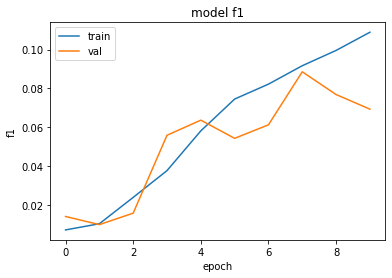

In [47]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [48]:
preds = model.predict(X_valid).reshape(-1)

In [51]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     61266
           1       0.55      0.04      0.07      4041

    accuracy                           0.94     65307
   macro avg       0.74      0.52      0.52     65307
weighted avg       0.92      0.94      0.91     65307



In [61]:
inputs = tf.keras.layers.Input(shape=(100))
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=40)(inputs)

conv_1 = tf.keras.layers.Conv1D(kernel_size=10, filters=10, strides=1)(embeddings)
conv_2 = tf.keras.layers.Conv1D(kernel_size=10, filters=20, strides=1)(conv_1)
pool_1 = tf.keras.layers.AveragePooling1D()(conv_2)
drop_1 = tf.keras.layers.Dropout(0.1)(pool_1)
conv_3 = tf.keras.layers.Conv1D(kernel_size=10, filters=30, strides=1)(drop_1)
pool_2 = tf.keras.layers.AveragePooling1D()(conv_3)
drop_2 = tf.keras.layers.Dropout(0.1)(pool_2)
conv_4 = tf.keras.layers.Conv1D(kernel_size=10, filters=40, strides=1)(drop_2)
conv_5 = tf.keras.layers.Conv1D(kernel_size=1, filters=40, strides=1)(conv_4)
pool_3 = tf.keras.layers.AveragePooling1D()(conv_5)
drop_3 = tf.keras.layers.Dropout(0.1)(pool_3)
conv_6 = tf.keras.layers.Conv1D(kernel_size=1, filters=40, strides=1)(drop_3)
conv_7 = tf.keras.layers.Conv1D(kernel_size=1, filters=40, strides=1)(conv_6)
pool_4 = tf.keras.layers.AveragePooling1D()(conv_7)
drop_4 = tf.keras.layers.Dropout(0.1)(pool_4)


concat = tf.keras.layers.Flatten()(drop_1)
dense_1 = tf.keras.layers.Dense(64, activation='relu')(concat)
dense_2 = tf.keras.layers.Dense(64, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [62]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=3000,
         epochs=15)

Train on 1240815 samples, validate on 65307 samples
Epoch 1/15
1240815/1240815 [==============================] - 155s 125us/sample - loss: 0.2163 - f1: 5.0653e-04 - val_loss: 0.2000 - val_f1: 0.0000e+00
Epoch 2/15
1240815/1240815 [==============================] - 155s 125us/sample - loss: 0.1917 - f1: 0.0063 - val_loss: 0.1904 - val_f1: 0.0101
Epoch 3/15
1240815/1240815 [==============================] - 159s 128us/sample - loss: 0.1858 - f1: 0.0204 - val_loss: 0.1869 - val_f1: 0.0349
Epoch 4/15
1240815/1240815 [==============================] - 160s 129us/sample - loss: 0.1826 - f1: 0.0433 - val_loss: 0.1845 - val_f1: 0.0485
Epoch 5/15
1240815/1240815 [==============================] - 166s 134us/sample - loss: 0.1805 - f1: 0.0693 - val_loss: 0.1828 - val_f1: 0.0756
Epoch 6/15
1240815/1240815 [==============================] - 166s 134us/sample - loss: 0.1782 - f1: 0.0960 - val_loss: 0.1804 - val_f1: 0.1069
Epoch 7/15
1240815/1240815 [==============================] - 170s 137us/sam

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


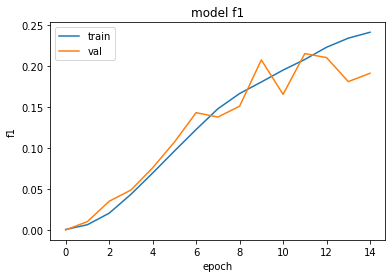

In [63]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [64]:
preds = model.predict(X_valid).reshape(-1)

In [65]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     61266
           1       0.57      0.12      0.19      4041

    accuracy                           0.94     65307
   macro avg       0.76      0.55      0.58     65307
weighted avg       0.92      0.94      0.92     65307

